## Example for ImArray
ImArray is a software to image an object in the sky by an array of ground Telescopes
Copyright (C) 2016  Thomas Vuillaume

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>

The author may be contacted @
thomas.vuillaume@lapp.in2p3.fr

Let's start with some imports

In [1]:
import geometry as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
import time
import math
import object as obj
import CameraImage as ci
import Hillas as hillas
import os
import vizualisation as viz

In [2]:
%matplotlib inline

We can define some shower parameters:

In [4]:
shower = obj.shower()

shower.impact_point = np.array([0,250,0])

#shower direction
shower.alt = math.radians(76)
shower.az = math.radians(0)

#pointing direction
talt = math.radians(74)
taz = math.radians(0)

#shower parameters
shower_top = 15000
shower_length = 12000
shower_width = 400

shower.number_of_particles = 50000

Here, our shower is a geometrical object (an ellpisoid in this case) randomly filled with points:

In [5]:
# shower = obj.random_ellipsoide(shower_top, shower_length, shower_width, salt, saz, impact_point, npoints)
shower.random_ellipsoide(shower_top, shower_length, shower_width)

Let's now define a telescopes array configuration:

In [6]:
tel_normal = geo.altaz_to_normal(talt,taz)

tel1 = geo.Telescope([500,100,-100],tel_normal,0)
tel2 = geo.Telescope([-10,300,100],tel_normal,0)
tel3 = geo.Telescope([-500,400,10],tel_normal,0)
tel4 = geo.Telescope([-350,-500,0],tel_normal,0)
tel5 = geo.Telescope([600,-100,150],tel_normal,0)
tel6 = geo.Telescope([0,200,0],tel_normal,0)
tel7 = geo.Telescope([80,0,0],tel_normal,0)
tel8 = geo.Telescope([-80,0,0],tel_normal,0)
tel9 = geo.Telescope([0,-80,0],tel_normal,0)
tel10 = geo.Telescope([0,80,0],tel_normal,0)
tel11 = geo.Telescope([0,80,0], geo.altaz_to_normal(20,180) ,0)

alltel = [tel1, tel2, tel3, tel4, tel5, tel6, tel11]

The telecopes positions can also be load from a data file with:

In [24]:
alltel = geo.load_telescopes("data/3HB1-NG-tels.txt")
tab = alltel[0].pixel_tab
for tel in alltel:
    tel.pixel_tab = tab
    tel.normal = tel_normal

101  telescopes loaded


We can check that no pair of telescopes are set at the same location:

In [7]:
geo.telescopes_unicity(alltel)

True

Let's vizualise what we have done so far:

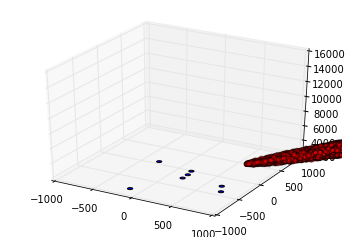

In [10]:
viz.plot_shower3d(shower.array,alltel)

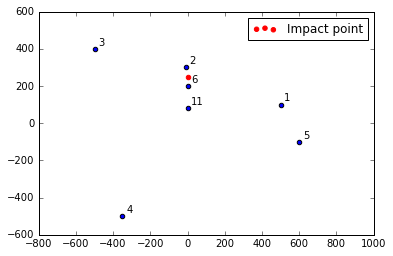

In [11]:
plt.scatter(shower.impact_point[0], shower.impact_point[1], color='red', label='Impact point')
viz.plot_array(alltel)

In [12]:
trigger_intensity = 100.
noise = 0

In [13]:
ci.array_shower_imaging(shower.array, alltel, noise)

One can vizualise a telescope camera image:

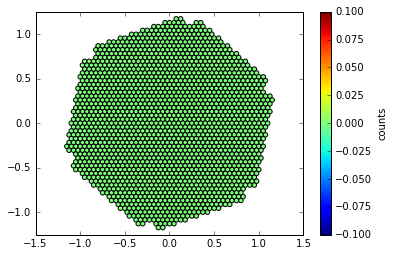

In [14]:
viz.display_camera_image(alltel[0])

or all at the same time:

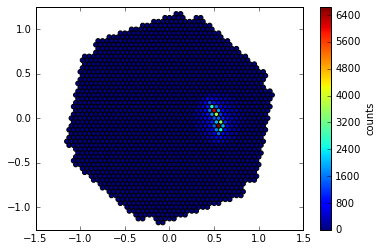

In [101]:
viz.display_stacked_cameras(alltel)

We can now make two Hillas reconstruction:

2


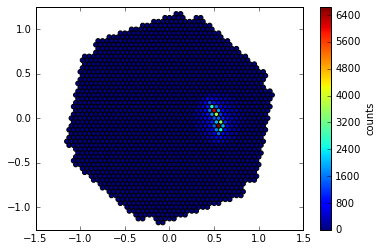

In [102]:
# Compute all the Hillas parameters
HP, triggered_telescopes = hillas.array_hillas_parameters(alltel, trigger_intensity)
print(len(triggered_telescopes))

viz.display_stacked_cameras(triggered_telescopes)

pa = hillas.impact_parameter_average(triggered_telescopes, HP, talt, taz)
p = hillas.impact_parameter_ponderated(triggered_telescopes, HP, talt, taz)

And compare the results:

In [103]:
print("Real impact parameter : ", impact_point)
print("Reconstruction with simple average = %s \tError = %.2fm" % (pa, math.sqrt(((impact_point-pa)**2).sum())))
print("Reconstruction with ponderation and cut = %s \tError = %.2fm" % (p, math.sqrt(((impact_point-p)**2).sum())))

Real impact parameter :  [  0 250   0]
Reconstruction with simple average = [1.4928660460538099, 246.30408812355057, 0.0] 	Error = 3.99m
Reconstruction with ponderation and cut = [1.4928660460538099, 246.30408812355057, 0.0] 	Error = 3.99m



Telescope number  2
Type  lst
Camera type: 0
Center  [-10 300 100]
normal  [ 0.27563736  0.          0.9612617 ]
Focale  16
Pixel position datafile  data/PosPixel_0.txt
[  4.29120000e+04   5.06579162e-01   7.49663448e-02   1.32381362e-01
   1.26572204e-01   5.12096085e-01   1.46919147e-01   6.19886426e-01
   4.55878446e-01]


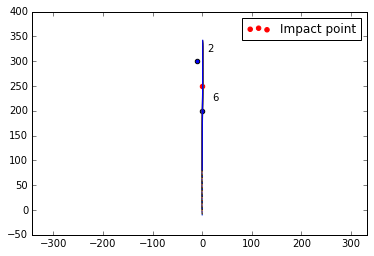

In [104]:
plt.scatter(impact_point[0], impact_point[1], color='red', label='Impact point')
viz.plot_array(triggered_telescopes)
x = np.linspace(0,100)
HP = np.array(HP)
# for (hp,tel) in zip(HP, triggered_telescopes):
tel = triggered_telescopes[0]
plt.plot(np.array([x*np.cos(hp[6]) + tel.center[0], x*np.sin(hp[6]) +tel.center[1] ]));
tel.display_info()
print(HP[0])

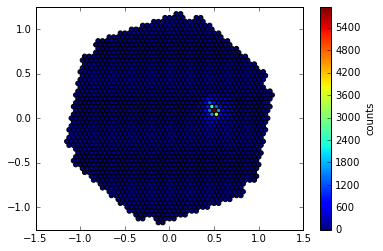

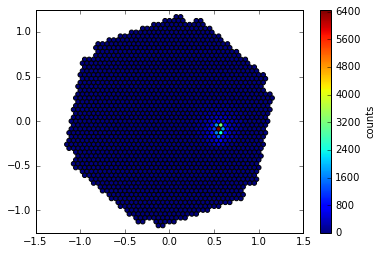

In [105]:
for tel in triggered_telescopes:
    tel.display_camera()
    plt.plot(x*np.)
    plt.show()